# Important! 
When initially opening the notebook there should be a text to the right of the "Help" menu saying "Changes will not be saved". 
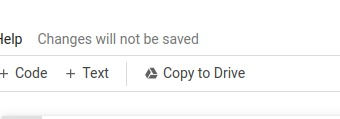

To ensure you can make changes to the notebook save a copy of it to your own drive and work on that one. You can do that by going to "File" -> "Save a copy in Drive".

**Failing to do so will result in code loss!**

 **Note** Make sure you are the only one that has access to it!


In [1]:
#@markdown #Image Processing - 67829. { display-mode: "form" }
#@markdown ##Exercise 5:  Deep Style Image Prior
#@markdown ##Due date: 26.01.2023 at 23:59
#@title{ display-mode: "form" }

#@markdown
#@markdown This exercise is a bit different than the rest of the exercises in the course.
#@markdown The submissions will be a PDF file with your answers and results to the exercise 
#@markdown as well as some files so that we can verify the authenticity of your results.
#@markdown This notebook provides the basic code, but you do not need to adhere to some specific API 
#@markdown and we will not be running unit tests on your code. 
#@markdown We will however, be going over your code and running it manually. 
#@markdown Moreover, we will be running tests to ensure the authenticity of your solution and detect plagiarism
#@markdown
#@markdown
#@markdown Before you start working on the exercise it is recommended that you review the lecture slides covering neural networks,
#@markdown
#@markdown 
#@markdown **NOTE**: Neural networks are typically trained on GPUs, without GPUs training takes much longer. 
#@markdown To enable GPU tranining click on "Runtime" -> "Change runtime type" -> "GPU" -> "SAVE".
#@markdown
#@markdown **NOTE**: A short guide on debugging your code using colab is availble [here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb#scrollTo=qnIn-rWFqoww).

#@markdown But first, we have to download all of the dependencies and install them.
#@markdown Play this cell to download it and get everything ready. markdown This may take a few minutes.

 
!mkdir impr_ex5_resources
%cd impr_ex5_resources
#!wget "https://www.cs.huji.ac.il/~impr/shape_predictor_68_face_landmarks.dat" -O shape_predictor_68_face_landmarks.dat 
#!wget "https://www.cs.huji.ac.il/~impr/align_faces.py" -O align_faces.py 
!wget "https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar" -O stylegan2-ada-pytorch.tar
!tar -xvf stylegan2-ada-pytorch.tar
!rm -f stylegan2-ada-pytorch.tar

import sys
ROOT_PATH="/content/impr_ex5_resources/stylegan2-ada-pytorch"
sys.path.append(ROOT_PATH)


!pip install ninja
!pip install mediapy
CHECKPOINTS_PATH = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"



import copy
import os
from time import perf_counter
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F

import dnnlib
import legacy
import numpy as np
from skimage.draw import line
from torch.nn.functional import conv2d,conv1d
import mediapy as media
from IPython.display import clear_output


mkdir: cannot create directory ‘impr_ex5_resources’: File exists
/content/impr_ex5_resources
--2023-01-18 13:22:29--  https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar
Resolving www.cs.huji.ac.il (www.cs.huji.ac.il)... 132.65.118.16
Connecting to www.cs.huji.ac.il (www.cs.huji.ac.il)|132.65.118.16|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar [following]
--2023-01-18 13:22:31--  https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar
Reusing existing connection to www.cs.huji.ac.il:443.
HTTP request sent, awaiting response... 200 OK
Length: 100364800 (96M) [application/x-tar]
Saving to: ‘stylegan2-ada-pytorch.tar’

stylegan2-ada-pytor 100%[===================>]  95.71M  9.72MB/s    in 11s     

2023-01-18 13:22:43 (8.68 MB/s) - ‘stylegan2-ada-pytorch.tar’ saved [100364800/100364800]

stylegan2-ada-pytorch/
stylegan2-ada-pytorch/metrics/
stylegan2-ada-pytorch/._dataset_tool

# Mounting Google Drive

In [2]:
#@markdown **NOTE**: It is strongly advised you save your results to Google 
#@markdown Drive as they will be deleted from Colab once it restarts. 
#@markdown To connect Google Drive run this cell. 
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Below is the root dir of your Google Drive. To choose the destenation of the dir to save and read from, create it in your Google Drive and add the relative path to the "GDRIVE_SAVE_REL_PATH" variable below.

In [3]:
ROOT_GDRIVE_PATH="/content/gdrive/MyDrive/"
GDRIVE_SAVE_REL_PATH = ""
FULL_GDRIVE_SAVE_PATH = ROOT_GDRIVE_PATH + GDRIVE_SAVE_REL_PATH

# General Variables

In [4]:
GAUSSIAN_BLUR_DEGRADATION= 'GAUSSIAN_BLUR_DEGRADATION'
GRAYSCALE_DEGRADATION = 'GRAYSCALE_DEGRADATION'
INPAINTING_DEGRADATION = 'INPAINTING_DEGRADATION'
NO_DEGRADATION= 'NO_DEGRADATION'


# Image Alignment

In [5]:
# The align_faces.py script takes in an input image path, an output image path, and a dat file path. The dat file is already downloaded for you, so leave it as it is. 
# It is advised that you save the files to google drive as restarting Colab will erase them.
!python "$ROOT_PATH/align_faces/align_faces.py" 'INPUT_IMAGE_PATH_AND_NAME' 'OUTPUT_IMAGE_PATH_AND_NAME' "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"

Traceback (most recent call last):
  File "/content/impr_ex5_resources/stylegan2-ada-pytorch/align_faces/align_faces.py", line 149, in <module>
    align_face(sys.argv[1],sys.argv[2],sys.argv[3])
  File "/content/impr_ex5_resources/stylegan2-ada-pytorch/align_faces/align_faces.py", line 65, in align_face
    lm = get_landmark(input_path,landmark_model_path)
  File "/content/impr_ex5_resources/stylegan2-ada-pytorch/align_faces/align_faces.py", line 40, in get_landmark
    img = dlib.load_rgb_image(filepath)
RuntimeError: Unable to open file: INPUT_IMAGE_PATH_AND_NAME


In [6]:
!pip install --upgrade pillow
import cv2
import matplotlib.pyplot as plt
import imageio as iio
from torchvision import transforms


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# GAN Inversion

In [19]:
def run_latent_optimization(outdir,
    degradation_mode,
    G,
    imgs_to_disply_dict,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    mask_                       = None,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    latent_dist_reg_weight     = 0.001,
    device: torch.device
    
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore
  
    # Compute w stats.
    print(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 18, C]
    w_avg_original = torch.from_numpy(w_avg).to(device).float()
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)
    
    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)

    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) 
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
    
    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    loss_arr = []
    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth image from opt_w
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = w_opt + w_noise
        synth_images = G.synthesis(ws, noise_mode='const')
        
        # Prep to save synth image
        synth_image_save = (synth_images + 1) * (255/2)
        synth_image_save = synth_image_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    

        synth_images_degraded = synth_images.clone()
        if  degradation_mode == INPAINTING_DEGRADATION:
          indices = (((mask_[0]//255) == 0).nonzero(as_tuple=True))
          synth_images_degraded[0][indices]=-1
        elif degradation_mode == GRAYSCALE_DEGRADATION:
           synth_images_degraded[0] = rgb_to_grayscale_3channels(synth_images_degraded[0])
        elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
            kernel = np.random.randint(3,200)
            if kernel %2==0:
              kernel+=1
            gaussian_blur = transforms.GaussianBlur(kernel_size=(kernel, kernel), sigma = (5,5))
            synth_images_degraded = gaussian_blur(synth_images_degraded)
            
        
        # Prep to save and show images
        synth_image_degraded_save = (synth_images_degraded + 1) * (255/2)
        synth_image_degraded_save = synth_image_degraded_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()  
        
        if step % 20 == 0:
          imgs_to_disply_dict["Generated Image"]=synth_image_save
          imgs_to_disply_dict["Generated Degraded Image"]=synth_image_degraded_save
          clear_output(wait=True)
          media.show_images(imgs_to_disply_dict,height=256)
        if step % 100 == 0:
          PIL.Image.fromarray(synth_image_save, 'RGB').save(f'{outdir}/intermidiate_%d_not_degraded.png'%step)
          PIL.Image.fromarray(synth_image_degraded_save, 'RGB').save(f'{outdir}/intermidiate_%d_degraded.png'%step)


        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images_degraded = (synth_images_degraded + 1) * (255/2)
        if synth_images_degraded.shape[2] > 256:
            synth_images_degraded = F.interpolate(synth_images_degraded, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images_degraded, resize_images=False, return_lpips=True)
        
        # Compute loss
        percep_loss = (target_features - synth_features).square().sum()
        latent_dist_reg = F.l1_loss(w_avg_original, w_opt)
        loss = percep_loss + reg_loss * regularize_noise_weight  + latent_dist_reg_weight * latent_dist_reg

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        loss_arr.append(float(loss))
        
        print(f'step {step+1:>4d}/{num_steps}: percep_loss {percep_loss:<4.2f} latent_dist_reg {latent_dist_reg:<4.2f} loss {float(loss):<5.2f}' )

        # Save inverted latent for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()
    return w_out, loss_arr

In [8]:

def invert_image(degradation_mode,
                   target_fname,
                   outdir,
                   mask_path = "",
                   seed=303,
                   num_steps=1000,
                   latent_dist_reg_weight=0.001):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % CHECKPOINTS_PATH)
    device = torch.device('cuda')
    with dnnlib.util.open_url(CHECKPOINTS_PATH) as fp:
        networks = legacy.load_network_pkl(fp)
        G = networks['G_ema'].requires_grad_(False).to(device)
        

    # Load target image.
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    target=torch.tensor([target_uint8.transpose([2, 0, 1])], device=device) 
    target_images = target[0].unsqueeze(0).to(device).to(torch.float32)

    mask = torch.NoneType
    if  degradation_mode == INPAINTING_DEGRADATION:

      # open mask file 
      mask_pil = PIL.Image.open(mask_path).convert('RGB')
      w, h = mask_pil.size
      s = min(w, h)
      mask_pil = mask_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
      mask_pil = mask_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
      mask_uint8 = np.array(mask_pil, dtype=np.uint8)
      mask=torch.tensor([mask_uint8.transpose([2, 0, 1])], device=device) 
      
      # create target image
      for i in range(3):
          target[0][i,:,:] = target[0][i,:,:] * (mask[0][i,:,:]//255).int().float()
    elif degradation_mode == GRAYSCALE_DEGRADATION:    
      target[0] = rgb_to_grayscale_3channels(target[0])
    elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
      pass

    #Save target image
    target_to_save = target.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(target_to_save, 'RGB').save(f'{outdir}/original_degraded_image.png')
    imgs_to_disply_dict = {
        "Original Image":target_uint8,
        "Original Degraded Image":target_to_save,
              }

    # Run latent optimization
    start_time = perf_counter()
    optimization_steps, loss_arr = run_latent_optimization(
        outdir,
        degradation_mode,
        G,
        imgs_to_disply_dict,
        target[0],
        mask_=mask,
        num_steps=num_steps,
        device=device,
        latent_dist_reg_weight=latent_dist_reg_weight
    )

    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')
    os.makedirs(outdir, exist_ok=True)

    # Save final inverted image and latent vector.
    inverted_latent = optimization_steps[-1]
    synth_image = G.synthesis(inverted_latent.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/final_inverted_image.png')
    np.savez(f'{outdir}/inverted_latent.npz', latent=inverted_latent.unsqueeze(0).cpu().numpy())
    
    return loss_arr

In [9]:
def plot_loss(loss_arr, num_of_steps):

  range = np.arange(num_of_steps).reshape(num_of_steps)
  loss_arr = np.array(loss_arr)

  plt.plot(range, loss_arr)
  plt.xlabel('num of steps')
  plt.ylabel('Loss')
  plt.show()

In [10]:
def inversion_q2():
  num_steps=600
  loss_arr = invert_image(NO_DEGRADATION, "/content/Image_Alignment_after.jpg",  "/content/inversion_output",
                   seed=303, num_steps=num_steps, latent_dist_reg_weight=0.10)
  plot_loss(loss_arr, num_steps)

In [11]:
def blure_image(filename):

  # Read the image from file
  image = cv2.imread(filename)

  # Apply the blur using the Gaussian blur function
  blurred_image = cv2.GaussianBlur(image, (49, 49), 0)

  # Save the blurred image to file
  cv2.imwrite("/content/blur_im.png",blurred_image)

In [12]:
def gaussian_blur_(image, kernel_size):
    sigma = 1
    size = kernel_size
    kernel = np.zeros((size, size))
    center = size // 2

    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
            
    kernel = kernel / kernel.sum() # normalize
    gaussian_kernel = torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0)
    g1=gaussian_kernel.clone()
    g2=gaussian_kernel.clone()
    gaussian_kernel = torch.cat((gaussian_kernel, g1, g2), dim=1).float()
    image[0]=torch.nn.functional.conv2d(image[0].cpu(), gaussian_kernel, padding=1)
    return image


In [23]:
def deblurring_q3(im_path, outdir):

  # for the firs time - create a blured image
  blure_im = blure_image("/content/Image_Alignment_after.jpg")

  invert_image(GAUSSIAN_BLUR_DEGRADATION, im_path,  outdir,
                   seed=303, num_steps=1000, latent_dist_reg_weight=0.00001)

In [14]:
def rgb_to_grayscale_3channels(rgb_tensor):
    R = rgb_tensor[0,:,:]
    G = rgb_tensor[1,:,:]
    B = rgb_tensor[2,:,:]
    gray =  0.299 * R + 0.587 * G + 0.114 * B
    return torch.cat((gray, gray, gray)).reshape(rgb_tensor.shape)

In [15]:
def colorization_q4(im_path, out_dir):
  invert_image(GRAYSCALE_DEGRADATION, im_path , out_dir,
                   seed=303, num_steps=1000, latent_dist_reg_weight=0.5)
  

In [36]:
def inpainting_q5(im_path, mask_path, out_dir):
  invert_image(INPAINTING_DEGRADATION, im_path , out_dir, mask_path=mask_path,
                   seed=303, num_steps=1000, latent_dist_reg_weight=0.01)

Original Image,Original Degraded Image,Generated Image,Generated Degraded Image

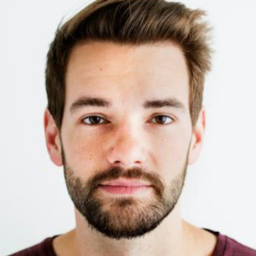
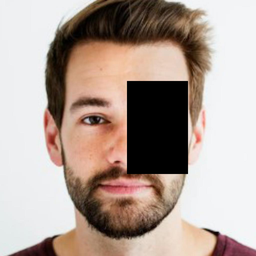
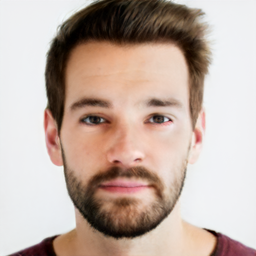
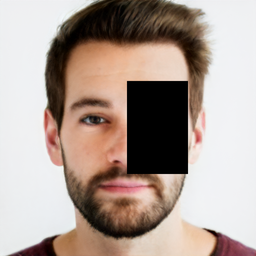

step  981/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  982/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  983/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  984/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  985/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  986/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  987/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  988/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  989/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  990/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  991/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  992/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  993/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  994/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  995/1000: percep_loss 0.06 latent_dist_reg 0.20 loss 0.08 
step  996/1000: percep_lo

In [37]:
if __name__ == '__main__':

#### q2 ####

    inversion_q2()

##########################Image Reconstruction Tasks############################

#### q3 - blure ####

    # my image:
    deblurring_q3("/content/blur_im.png", "/content/my_deblur_output")

    # Yann LeCun image:
    deblurring_q3("/content/yann_lecun_blur.png", "/content/yann_deblur_output")
  

#### q4 - grayscale ####

    # my image:
    colorization_q4("/content/Image_Alignment_after.jpg","/content/grayscale_output")

    # alan_turing_grayscale
    colorization_q4("/content/alan_turing_grayscale.png","/content/alan_turing_output")

#### q5 - inpainting ####

    # my image:
    inpainting_q5("/content/Image_Alignment_after.jpg", "/content/fei_fei_li_inpainting_mask.png", "/content/inpainting_output")


    # fei_fei_li_inpainting:
    inpainting_q5("/content/fei_fei_li_original.png", "/content/fei_fei_li_inpainting_mask.png", "/content/fei_fei_li_output")

  
    